In [10]:
# === Helpers CORRECTOS (deja solo estos; borra/ comenta los anteriores) ===
def add_peak_vertical(ax, xh_peak: float, y_peak: float, color="0.15"):
    """
    Traza una línea vertical punteada desde el eje X (abajo) hasta y_peak.
    Usa axvline para que el extremo inferior toque exactamente el eje.
    """
    y0, y1 = ax.get_ylim()
    if y1 == y0:
        return
    frac = (y_peak - y0) / (y1 - y0)          # altura relativa dentro del eje
    frac = max(0.0, min(1.0, frac))           # acotar por seguridad
    ax.axvline(
        xh_peak, ymin=0.0, ymax=frac,
        color=color, linestyle=(0, (4, 4)), linewidth=0.9, alpha=0.65, zorder=1
    )

def label_tmax_topright(ax, xh_peak: float, y_peak: float, color="0.15", text_prefix="Tmáx"):
    # etiqueta en esquina superior derecha con flecha hacia el pico (sin hora)
    txt = f"{text_prefix} {y_peak:.1f} °C"
    ax.annotate(
        txt,
        xy=(xh_peak, y_peak),                 # punta de la flecha (dato)
        xytext=(0.98, 0.98),                  # esquina sup-der
        textcoords="axes fraction",
        ha="right", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=color, alpha=0.95),
        arrowprops=dict(arrowstyle="->", color=color, lw=1.0),
        color="black", zorder=6
    )



In [11]:
# %%
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from pathlib import Path
from scipy.signal import savgol_filter

plt.rcParams["axes.grid"] = True

# === AJUSTA estas rutas a tus CSV ===
FILES = {
    #Datos de primera fundida - apagar con "#"
    
    # "0%":  r"./mnt/data/datos_Prueba_30jul2025_1413_0PLR.csv",
    # "7.5%":r"./mnt/data/datos_Prueba_16ago2025_0938_7PLR.csv",
    # "15%": r"./mnt/data/datos_Prueba_20ago2025_1749_15PLR.csv",
    # "30%": r"./mnt/data/datos_Prueba_22ago2025_1856_30PLR_DPico.csv",
    
    #Datos de segunda fundida - apagar con "#"
    
    "0%":  r"./mnt/data/datos_Prueba_13ago2025_1937_0PLR.csv",
    "7.5%":r"./mnt/data/datos_Prueba_25ago2025_2000_7PLR_DPico.csv",
    "15%": r"./mnt/data/datos_Prueba_27ago2025_1804_15PLR.csv",
    "30%": r"./mnt/data/datos_Prueba_30ago2025_1028_30PLR.csv",
}

OUTDIR = Path("./salidas_concreto_grises_24h_vf")
OUTDIR.mkdir(exist_ok=True)


In [12]:
# %%
def ensure_odd(k: int) -> int:
    return k if k % 2 == 1 else k + 1

def load_concreto_exact(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    for col in ["Timestamp","Temp1 (°C)"]:
        if col not in df.columns:
            raise ValueError(f"{path}: falta columna '{col}'. Presentes: {list(df.columns)}")
    if "Temp2 (°C)" not in df.columns:
        df["Temp2 (°C)"] = np.nan
    if "Temp_DHT (°C)" not in df.columns:
        raise ValueError(f"{path}: falta 'Temp_DHT (°C)'.")

    df["Timestamp"]      = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Temp1 (°C)"]     = pd.to_numeric(df["Temp1 (°C)"], errors="coerce")
    df["Temp2 (°C)"]     = pd.to_numeric(df["Temp2 (°C)"], errors="coerce")
    df["Temp_DHT (°C)"]  = pd.to_numeric(df["Temp_DHT (°C)"], errors="coerce")

    df = df.dropna(subset=["Timestamp"]).sort_values("Timestamp").set_index("Timestamp")
    df["tc_avg"] = df["Temp1 (°C)"] if df["Temp2 (°C)"].notna().sum()==0 else df[["Temp1 (°C)","Temp2 (°C)"]].mean(axis=1)
    df["ambient"] = df["Temp_DHT (°C)"]
    return df[["tc_avg","ambient"]]

def smooth_resample_trim(df: pd.DataFrame, freq="2s", window=31, sg_window=61, sg_poly=3) -> pd.DataFrame:
    """
    Suavizado:
      1) Remuestreo regular (2 s) + interpolación temporal
      2) Ventana robusta centrada: mediana -> media
      3) Savitzky–Golay (window=61, polyorder=3)
      4) Tiempo relativo y recorte 0–24 h
    """
    window = ensure_odd(window)
    if sg_window != 0: sg_window = ensure_odd(sg_window)

    dfr = df.resample(freq).mean()
    dfr["tc_avg"]  = dfr["tc_avg"].interpolate("time", limit_direction="both")
    dfr["ambient"] = dfr["ambient"].interpolate("time", limit_direction="both")

    def roll(s):
        med = s.rolling(window=window, center=True, min_periods=max(3, window//3)).median()
        mea = med.rolling(window=window, center=True, min_periods=max(3, window//3)).mean()
        return mea

    dfr["tc_avg_smooth"]  = roll(dfr["tc_avg"])
    dfr["ambient_smooth"] = roll(dfr["ambient"])

    def sg(series):
        arr = series.to_numpy()
        if sg_window and sg_window>3 and np.isfinite(arr).sum()>=sg_window:
            try:
                return savgol_filter(arr, window_length=sg_window, polyorder=sg_poly, mode="interp")
            except Exception:
                return arr
        return arr

    dfr["tc_avg_sg"]  = sg(dfr["tc_avg_smooth"])
    dfr["ambient_sg"] = sg(dfr["ambient_smooth"])

    t0 = dfr.index[0]
    dfr["tiempo_rel_min"] = (dfr.index - t0).total_seconds()/60.0
    dfr = dfr.loc[dfr["tiempo_rel_min"] <= 24*60]     # recorta a 24 h
    dfr["tiempo_rel_h"]   = dfr["tiempo_rel_min"]/60.0
    return dfr


In [13]:
# %%
def intersections_tc_vs_dht(df_s: pd.DataFrame) -> pd.DataFrame:
    y1 = df_s["tc_avg_sg"].to_numpy()
    y2 = df_s["ambient_sg"].to_numpy()
    t  = df_s["tiempo_rel_h"].to_numpy()  # horas
    d  = y1 - y2
    hits = []
    for i in range(len(d)-1):
        a, b = d[i], d[i+1]
        if not (np.isfinite(a) and np.isfinite(b)): 
            continue
        if a == 0:
            hits.append((t[i], y1[i]))
        if a*b < 0 or b == 0:
            denom = (a - b)
            if denom == 0: 
                continue
            alpha = a / denom
            if 0 <= alpha <= 1:
                t_eq = t[i] + alpha*(t[i+1]-t[i])
                y_eq = y1[i] + alpha*(y1[i+1]-y1[i])
                hits.append((t_eq, y_eq))
    if not hits:
        return pd.DataFrame(columns=["t_h","temp_eq"])
    out = pd.DataFrame(hits, columns=["t_h","temp_eq"]).drop_duplicates().sort_values("t_h")
    # Mantener solo los cruces en 0–24 h (por si borde)
    return out[(out["t_h"] >= 0) & (out["t_h"] <= 24)]
    

In [14]:
# Encender / apagar intersecciones (si no existe, créala con True)
try:
    SHOW_INTERSECTIONS
except NameError:
    SHOW_INTERSECTIONS = True  # pon False si no quieres ver los puntos


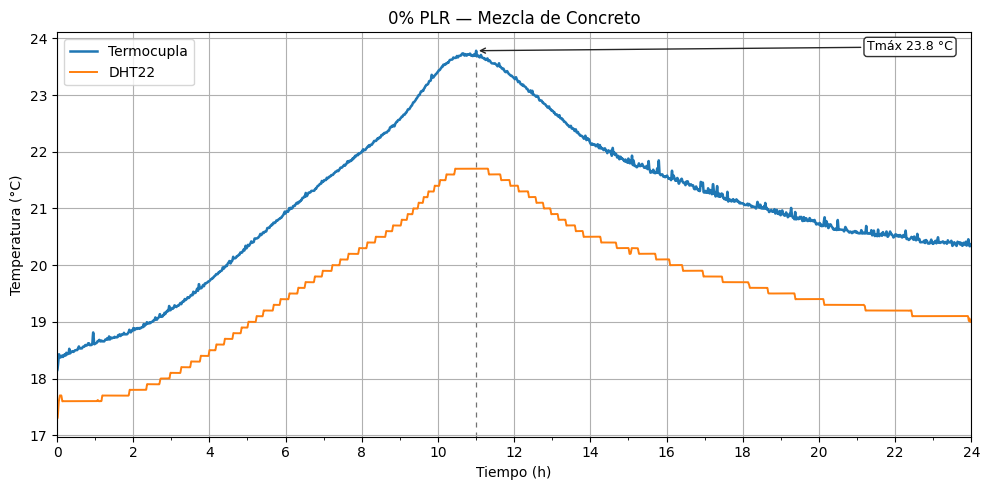

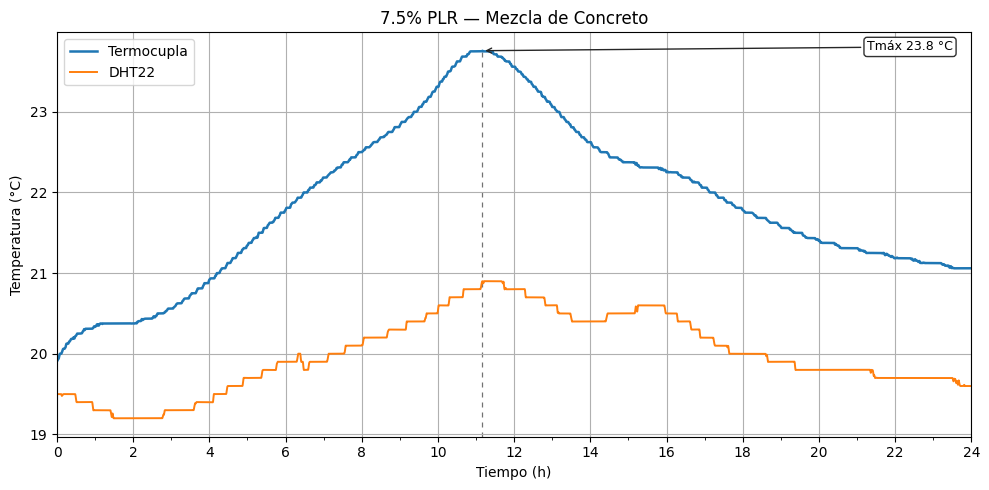

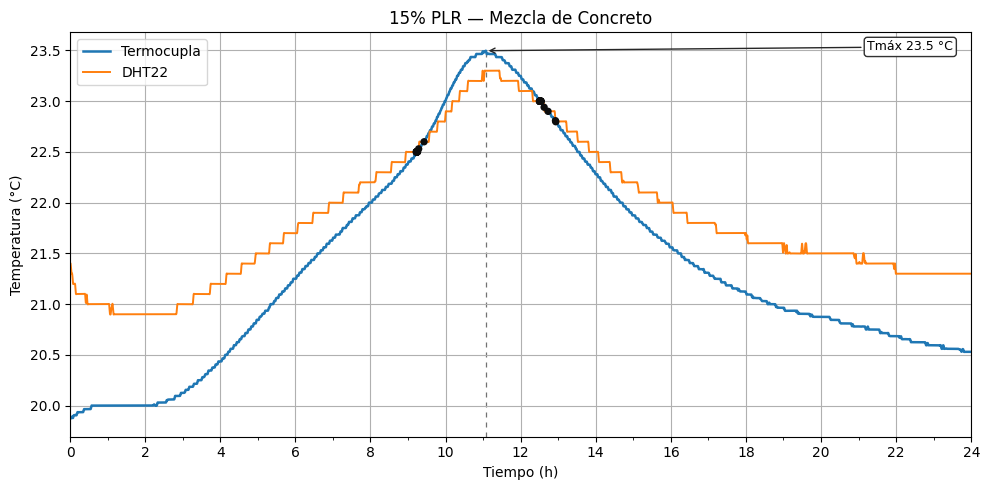

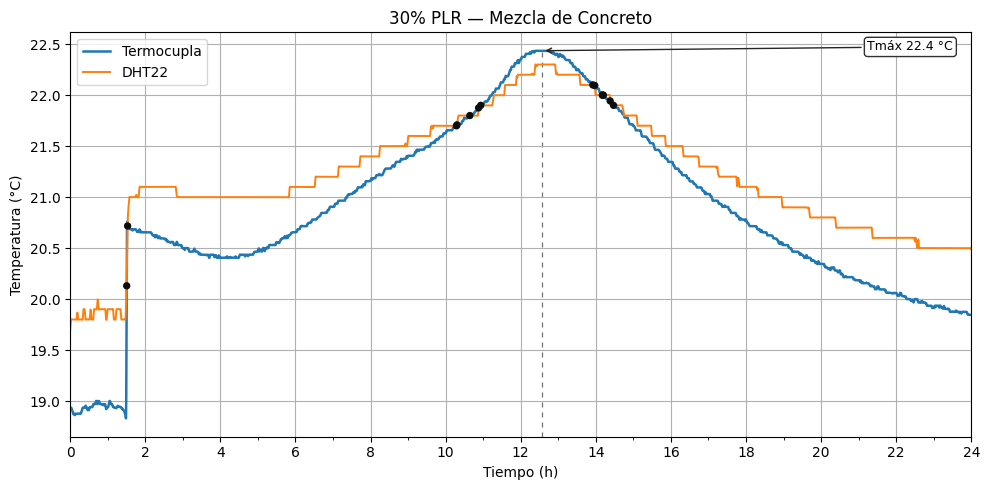

In [18]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

processed = {}
intersections_map = {}

for label, path in FILES.items():
    if not Path(path).exists():
        print(f"[WARN] no existe: {path}")
        continue

    df = load_concreto_exact(path)
    ds = smooth_resample_trim(df, freq="2s", window=31, sg_window=61, sg_poly=3)
    processed[label] = ds

    # ⬇️ Calcular intersecciones para CADA mezcla (0%, 7.5%, 15%, 30%)
    inters = intersections_tc_vs_dht(ds)
    intersections_map[label] = inters

    # ---- PLOT individual TC vs DHT (grises) ----
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(ds["tiempo_rel_h"], ds["tc_avg_sg"],  label="Termocupla",  linewidth=1.8)
    ax.plot(ds["tiempo_rel_h"], ds["ambient_sg"], label="DHT22", linewidth=1.4)

    # Pico Tmáx (tu lógica existente)
    idx_max = int(np.nanargmax(ds["tc_avg_sg"].to_numpy()))
    xh_peak = float(ds["tiempo_rel_h"].iloc[idx_max])
    y_peak  = float(ds["tc_avg_sg"].iloc[idx_max])

    # Ejes + leyenda arriba-derecha ANTES de la vertical (para tomar bien el y0)
    ax.set_title(f"{label} PLR — Mezcla de Concreto")
    ax.set_xlabel("Tiempo (h)")
    ax.set_ylabel("Temperatura (°C)")
    ax.set_xlim(0, 24)
    ax.xaxis.set_major_locator(MultipleLocator(2.0))
    ax.xaxis.set_minor_locator(MultipleLocator(1.0))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):d}" if 0 <= x <= 24 else ""))
    ax.legend(loc="upper left", frameon=True)

    # Línea vertical al Tmáx + etiqueta (tus helpers actuales)
    add_peak_vertical(ax, xh_peak, y_peak)
    label_tmax_topright(ax, xh_peak, y_peak, text_prefix="Tmáx")

    # ⬇️ Marcar intersecciones SOLO si existen y si SHOW_INTERSECTIONS=True
    if SHOW_INTERSECTIONS and not inters.empty:
        ax.scatter(inters["t_h"], inters["temp_eq"], s=28, color="0.05",
                   edgecolors="none", label="Intersecciones", zorder=5)

    fig.tight_layout()
    plt.show()
    fig.savefig(OUTDIR / f"{label.replace('%','pct')}_tc_vs_dht_gris_24h.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    # Guardar CSV limpio e intersecciones por mezcla
    ds[["tiempo_rel_min","tiempo_rel_h","tc_avg","ambient","tc_avg_sg","ambient_sg"]].to_csv(
        OUTDIR / f"{label.replace('%','pct')}_clean_24h.csv", index_label="timestamp"
    )
    inters.to_csv(OUTDIR / f"{label.replace('%','pct')}_intersecciones.csv", index=False)



In [23]:
# %% Comparativa — Promedio TC (0–24 h, grises) con Tmáx en la leyenda y líneas verticales al eje
from matplotlib.ticker import MultipleLocator, FuncFormatter
import numpy as np
import matplotlib.pyplot as plt

def fmt_horas_pares(x, pos):
    return f"{int(x):d}" if 0 <= x <= 24 and int(x)%2==0 else ""

labels_presentes = [k for k in ["0%","7.5%","15%","30%"] if k in processed]
if len(labels_presentes) < 2:
    raise RuntimeError("Se necesitan al menos dos datasets en 'processed' para la comparativa.")

# Rejilla común (0–24 h), 1 min
max_rel_h = min(processed[k]["tiempo_rel_h"].max() for k in labels_presentes)
max_rel_h = min(max_rel_h, 24.0)
grid_h = np.arange(0, max_rel_h, 1.0/60.0)  # 1 min

fig, ax = plt.subplots(figsize=(10,5))

# Guardaremos picos para las líneas verticales y para la leyenda
peaks = []   # [(label, xh_peak, y_peak)]

for label in ["0%","7.5%","15%","30%"]:
    if label not in processed:
        continue
    d  = processed[label]
    x  = d["tiempo_rel_h"].to_numpy()
    y  = d["tc_avg_sg"].to_numpy()
    yi = np.interp(grid_h, x, y)

    # Pico (Tmáx) en la serie interpolada
    i_peak = int(np.nanargmax(yi))
    xh_pk  = float(grid_h[i_peak])
    y_pk   = float(yi[i_peak])
    peaks.append((label, xh_pk, y_pk))

    # Serie en grises con marcadores discretos (cada 60 min)
    ax.plot(
        grid_h, yi,
        linestyle="-",
        linewidth=1.8,
        markevery=60, markersize=4,
        markerfacecolor="none"
        label=f"{label} — Tmáx {y_pk:.1f} °C",
        zorder=2
    )

# Ejes y leyenda (arriba–izquierda)
ax.set_title("Mezclas de Concreto en Variacion del Porcentaje de PLR")
ax.set_xlabel("Tiempo de Hidratación (h)")
ax.set_ylabel("Temperatura (°C)")
ax.set_xlim(0, 24)
ax.xaxis.set_major_locator(MultipleLocator(2.0))
ax.xaxis.set_minor_locator(MultipleLocator(1.0))
ax.xaxis.set_major_formatter(FuncFormatter(fmt_horas_pares))
ax.legend(loc="upper left", frameon=True)

# Dibujar líneas punteadas verticales para cada Tmáx
# Usamos axvline con ymin/ymax fraccionales para que toquen EXACTO el eje X.
y0, y1 = ax.get_ylim()
for label, xh_pk, y_pk in peaks:
    frac = 0.0 if y1 == y0 else max(0.0, min(1.0, (y_pk - y0)/(y1 - y0)))
    ax.axvline(
        xh_pk, ymin=0.0, ymax=frac,
        linestyle=(0, (4, 4)), linewidth=0.9, alpha=0.65, zorder=1
    )

fig.tight_layout()
plt.show()
fig.savefig(OUTDIR / "comparativa_tcavg_black_Tmax_en_leyenda_y_vlines.png", dpi=300, bbox_inches="tight")
plt.close(fig)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3189475162.py, line 43)